In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device(type='mps')

In [3]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
print("Train data:\n", train_data)
print("\nTest data:\n", test_data)

Train data:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Test data:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


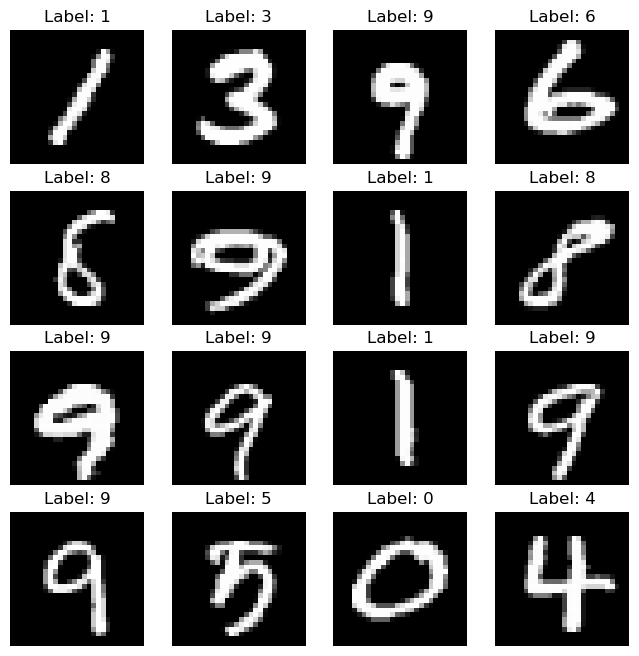

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# train
epochs = 10
train_loss = []

for epoch in range(epochs):
    epoch_loss = []

    # set the model in training phase
    model.train()

    for batch_idx, (data, target) in enumerate(train_dataloader):
        # zero the parameter gradients
        # this is because the gradients are accumulated
        # so we need to zero them out at each iteration
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(data)
        loss = loss_fn(output, target)

        # we save the epoch loss to plot it later
        # it is multiplied by the batch size to account for the fact that
        # the loss is averaged over the batch
        epoch_loss.append(loss.item() * data.size(0))

        loss.backward()
        optimizer.step()

        # print statistics
        if batch_idx % 400 == 0:
            print(f"Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}")
    train_loss.append(sum(epoch_loss) / len(train_data))

Epoch: 0, Batch: 0, Loss: 2.2953178882598877
Epoch: 0, Batch: 400, Loss: 0.1260863095521927
Epoch: 0, Batch: 800, Loss: 0.09389975666999817
Epoch: 1, Batch: 0, Loss: 0.09787891060113907
Epoch: 1, Batch: 400, Loss: 0.11758307367563248
Epoch: 1, Batch: 800, Loss: 0.036535874009132385
Epoch: 2, Batch: 0, Loss: 0.046887561678886414
Epoch: 2, Batch: 400, Loss: 0.1413286328315735
Epoch: 2, Batch: 800, Loss: 0.06275244057178497
Epoch: 3, Batch: 0, Loss: 0.03601439297199249
Epoch: 3, Batch: 400, Loss: 0.015198128297924995
Epoch: 3, Batch: 800, Loss: 0.09274444729089737
Epoch: 4, Batch: 0, Loss: 0.03338999301195145
Epoch: 4, Batch: 400, Loss: 0.07038191705942154
Epoch: 4, Batch: 800, Loss: 0.031227435916662216
Epoch: 5, Batch: 0, Loss: 0.026214195415377617
Epoch: 5, Batch: 400, Loss: 0.08040269464254379
Epoch: 5, Batch: 800, Loss: 0.036881931126117706
Epoch: 6, Batch: 0, Loss: 0.011896200478076935
Epoch: 6, Batch: 400, Loss: 0.02070874534547329
Epoch: 6, Batch: 800, Loss: 0.007654137443751097
E

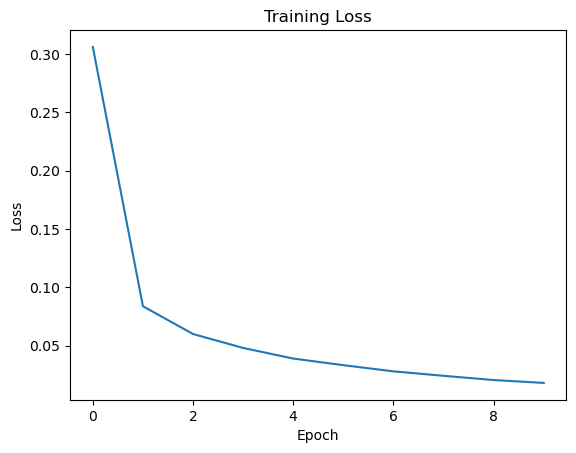

In [11]:
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [17]:
# set model to evaluation mode
model.eval()

# variables to keep track of accuracy
test_loss = []
correct = 0
total = 0

# we don't need to compute gradients for the test set
with torch.no_grad():
    for data, target in test_dataloader:
        output = model(data)
        loss = loss_fn(output, target)
        test_loss.append(loss.item() * data.size(0))
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"Test Loss: {sum(test_loss) / len(test_data)}")
print(f"Test Accuracy: {100 * correct / total}%")

Test Loss: 0.03719360748641193
Test Accuracy: 98.71%
